In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
class CSVReader:
    def __init__(self, directory_path,cleaned_csv_path):
        self.directory_path = directory_path
        self.cleaned_csv_path = cleaned_csv_path

    def clean_csv_files(self):
        # Crear la carpeta cleaned_csv si no existe
        cleaned_csv_path = os.path.join(self.directory_path, 'cleaned_csv')
        if not os.path.exists(cleaned_csv_path):
            os.makedirs(cleaned_csv_path)
        
        # Leer cada archivo CSV en el directorio
        for file_name in os.listdir(self.directory_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(self.directory_path, file_name)
                df = pd.read_csv(file_path)
                
                # Eliminar filas duplicadas
                df = df.drop_duplicates()
                
                # Guardar el archivo en la carpeta cleaned_csv con el mismo nombre
                cleaned_file_path = os.path.join(cleaned_csv_path, file_name)
                df.to_csv(cleaned_file_path, index=False)

    def read_csv_files(self):
        dfs = []
        for file_name in os.listdir(self.cleaned_csv_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(self.directory_path, file_name)
                df = pd.read_csv(file_path)
                dfs.append(df)
        # Clasificar los datos en función del nombre de la columna 12
        dfs_sorted = sorted(dfs, key=lambda x: (x.columns[11] == 'Not Sure', x.columns[11] == 'No', x.columns[11] == 'Yes'))
        return dfs_sorted
    
    def plot_csv_files(self):
        for df in self.read_csv_files():
            fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            axs[0].plot(df.iloc[:, 0:3])
            axs[0].set_title(df.columns[10]+' FeedBack: '+df.columns[11] + ' Respuesta modelo: '+df.columns[12]+' Acc Sensor')  # Utiliza el nombre de la columna 11 como título
            axs[1].plot(df.iloc[:, 3:6])
            axs[1].set_title(df.columns[10]+' FeedBack: '+df.columns[11] + ' Respuesta modelo: '+df.columns[12]+ ' Gyro Sensor')  # Utiliza el nombre de la columna 12 como título
            plt.show()


    def count_csv_files_by_column_11(self):
        csv_counts = {}
        for df in self.read_csv_files():
            column_11_name = df.columns[11]
            if column_11_name in csv_counts:
                csv_counts[column_11_name] += 1
            else:
                csv_counts[column_11_name] = 1

        df_counts = pd.DataFrame(list(csv_counts.items()), columns=['Feedback', 'Count'])
        return df_counts
    
    def remove_not_sure_csv_files(self):
        dfs = self.read_csv_files()
        dfs_filtered = [df for df in dfs if df.columns[11] != 'Not Sure']
        return dfs_filtered
    
    def generate_cm_experiment(self):
        y_true = []
        y_pred = []
        for df in self.remove_not_sure_csv_files():
                y_true.append(df.columns[11])
                y_pred.append(df.columns[12])

        y_true = np.array(y_true)
        y_true = np.where(y_true == 'Yes', 1, 0)
        y_pred = np.array(y_pred)
        y_pred = np.where(y_pred == '1', 1, 0)
        # accuracy = accuracy_score(y_true, y_pred)
        # precision = precision_score(y_true, y_pred)
        # recall = recall_score(y_true, y_pred)
        # f1 = f1_score(y_true, y_pred)
        # print('Accuracy: ', accuracy)
        # print('Precision: ', precision)
        # print('Recall: ', recall)
        # print('F1: ', f1)n
        cm = confusion_matrix(y_true, y_pred)
        cm = np.array(cm)
        df_cm = pd.DataFrame(cm, columns=['Predicción 0', 'Predicción 1'], index=['Real 0', 'Real 1'])
        print(df_cm)
        TP = cm[0, 0]
        FN = np.sum(cm[0, 1:])
        TN = np.sum(cm[1:, 1:])
        FP = np.sum(cm[1:, 0])

        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        npv = TN / (TN + FN) if (TN + FN) != 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
        fdr = FP / (FP + TP) if (FP + TP) != 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
        mcc = (TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5 if ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) != 0 else 0

        # Imprimir las métricas de evaluación
        print('Sensitivity:', sensitivity)
        print('Specificity:', specificity)
        print('Precision:', precision)
        print('Negative Predictive Value:', npv)
        print('False Positive Rate:', fpr)
        print('False Discovery Rate:', fdr)
        print('False Negative Rate:', fnr)
        print('Accuracy:', accuracy)
        print('F1 Score:', f1_score)
        print('Matthews Correlation Coefficient:', mcc)
        return cm
    
    def generate_cm_windows(self):
        y_true = []
        y_pred = []
        y_true1 = []
        y_pred1 = []
        for df in self.remove_not_sure_csv_files():
            current_y_true = df.columns[11]
            y_pred1=df.iloc[:, 13:].columns.tolist()
            y_pred1=[int(float(x)) for x in y_pred1]
            y_pred.extend(y_pred1)
            y_true1=([current_y_true] * len(y_pred1))
            y_true.extend(y_true1)

        y_true = np.array(y_true)
        y_true = np.where(y_true == 'Yes', 1, 0)
        # accuracy = accuracy_score(y_true, y_pred)
        # precision = precision_score(y_true, y_pred)
        # recall = recall_score(y_true, y_pred)
        # f1 = f1_score(y_true, y_pred)
        # print('Accuracy: ', accuracy)
        # print('Precision: ', precision)
        # print('Recall: ', recall)
        # print('F1: ', f1)n
        cm = confusion_matrix(y_true, y_pred)
        cm = np.array(cm)
        df_cm = pd.DataFrame(cm, columns=['Predicción 0', 'Predicción 1'], index=['Real 0', 'Real 1'])
        print(df_cm)
        TP = cm[0, 0]
        FN = np.sum(cm[0, 1:])
        TN = np.sum(cm[1:, 1:])
        FP = np.sum(cm[1:, 0])

        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        npv = TN / (TN + FN) if (TN + FN) != 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
        fdr = FP / (FP + TP) if (FP + TP) != 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
        mcc = (TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5 if ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) != 0 else 0

        # Imprimir las métricas de evaluación
        print('Sensitivity:', sensitivity)
        print('Specificity:', specificity)
        print('Precision:', precision)
        print('Negative Predictive Value:', npv)
        print('False Positive Rate:', fpr)
        print('False Discovery Rate:', fdr)
        print('False Negative Rate:', fnr)
        print('Accuracy:', accuracy)
        print('F1 Score:', f1_score)
        print('Matthews Correlation Coefficient:', mcc)
        return cm

  Feedback  Count
0      Yes      2
1       No      1


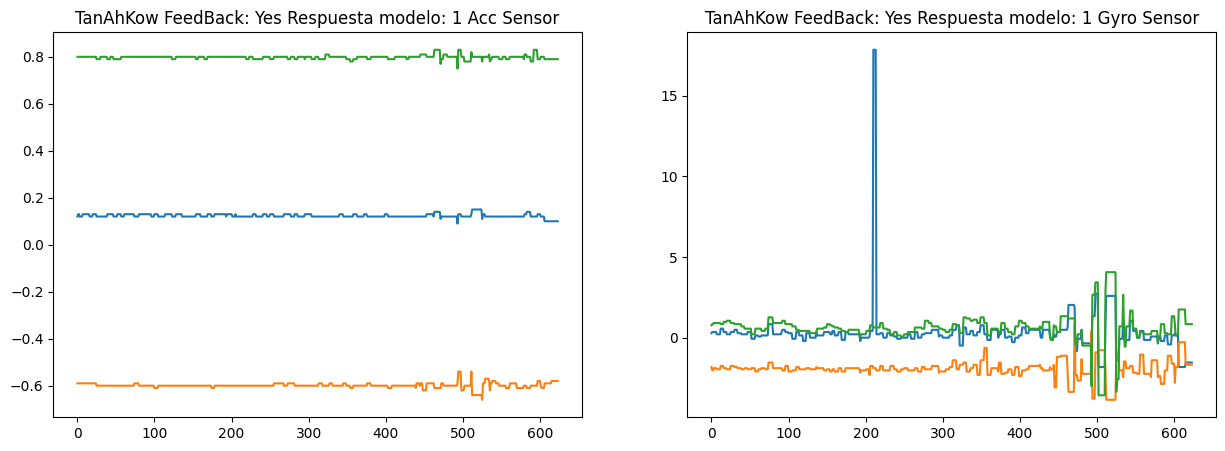

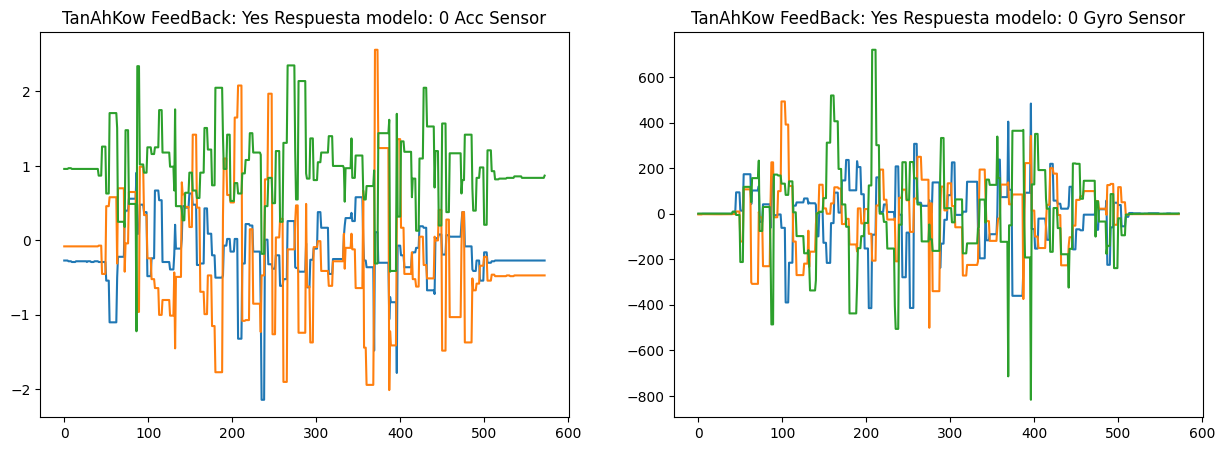

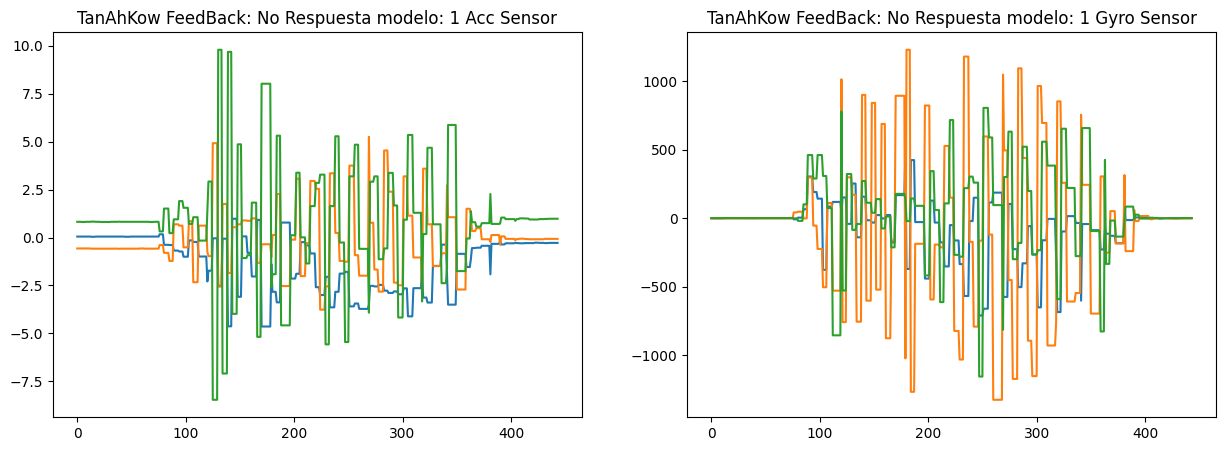

        Predicción 0  Predicción 1
Real 0             0             1
Real 1             1             1
Sensitivity: 0.0
Specificity: 0.5
Precision: 0.0
Negative Predictive Value: 0.5
False Positive Rate: 0.5
False Discovery Rate: 1.0
False Negative Rate: 1.0
Accuracy: 0.3333333333333333
F1 Score: 0.0
Matthews Correlation Coefficient: -0.5
        Predicción 0  Predicción 1
Real 0            20            27
Real 1            35            99
Sensitivity: 0.425531914893617
Specificity: 0.7388059701492538
Precision: 0.36363636363636365
Negative Predictive Value: 0.7857142857142857
False Positive Rate: 0.26119402985074625
False Discovery Rate: 0.6363636363636364
False Negative Rate: 0.574468085106383
Accuracy: 0.6574585635359116
F1 Score: 0.39215686274509803
Matthews Correlation Coefficient: 0.15666515197728278


In [4]:
directory_path = 'D:/SciprtPythonXiao/NimbleWindow/'## Path de los csv
cleaned_csv_path = 'D:/SciprtPythonXiao/NimbleWindow/cleaned_csv'## Path de los csv limpios
csv_reader = CSVReader(directory_path,cleaned_csv_path)
csv_reader.clean_csv_files()## funcion que limpia los csv
dfs = csv_reader.read_csv_files()## funcion que lee los csv
print(csv_reader.count_csv_files_by_column_11()) #Tabla de conteo de los datos
csv_reader.plot_csv_files() #Grafica las funciones
cmprocess = csv_reader.generate_cm_experiment() #Matriz de confusion
cmwindows = csv_reader.generate_cm_windows() #Matriz de confusion
